In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Configuration
DATA_DIR = "/kaggle/input/animal-kingdom-classification/AnimalTrainData/AnimalTrainData"
CSV_FILE = "/kaggle/input/csv-file/train.csv"
IMG_WIDTH, IMG_HEIGHT = 224, 224
NUM_CLASSES = 18

# Mapping animal names to numeric labels
LABEL_MAP = {
    "beaver": 0, "butterfly": 1, "cougar": 2, "crab": 3, "crayfish": 4,
    "crocodile": 5, "dolphin": 6, "dragonfly": 7, "elephant": 8, "flamingo": 9,
    "kangaroo": 10, "leopard": 11, "llama": 12, "lobster": 13, "octopus": 14,
    "pigeon": 15, "rhino": 16, "scorpion": 17
}

# Load dataset
print("[INFO] Loading dataset...")
df = pd.read_csv(CSV_FILE)
df['label'] = df['Class'].map(LABEL_MAP)
df.head()

# Augmentation function
def augment_image(image):
    augmentations = []

    # Flip horizontal
    augmentations.append(image.transpose(Image.FLIP_LEFT_RIGHT))

    # Flip vertical
    augmentations.append(image.transpose(Image.FLIP_TOP_BOTTOM))

    # Rotate
    for angle in [90, 180, 270]:
        augmentations.append(image.rotate(angle))

    # Brightness
    enhancer = ImageEnhance.Brightness(image)
    augmentations.append(enhancer.enhance(1.5))  # Increase brightness
    augmentations.append(enhancer.enhance(0.5))  # Decrease brightness

    return augmentations

# Preprocess training and validation data
print("[INFO] Splitting dataset into training and validation sets...")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Prepare training data
print("[INFO] Preparing training data with augmentation...")
train_images, train_labels = [], []

# Calculate class counts and find the maximum count
class_counts = train_df['label'].value_counts()
max_count = class_counts.max()

# Balance each class
for label, count in class_counts.items():
    # Get all rows for the current class
    class_rows = train_df[train_df['label'] == label]

    # Augment images until the number of images for this class matches the maximum count
    for _, row in class_rows.iterrows():
        img_path = os.path.join(DATA_DIR, row['ImageID'])
        try:
            img = Image.open(img_path).convert("RGB").resize((IMG_WIDTH, IMG_HEIGHT))
            train_images.append(np.asarray(img, dtype=np.float32) / 255.0)  # Original image
            train_labels.append(row['label'])

            # Augment if needed
            if count < max_count:
                augmented_imgs = augment_image(img)
                for aug_img in augmented_imgs:
                    if count >= max_count:
                        break
                    train_images.append(np.asarray(aug_img, dtype=np.float32) / 255.0)
                    train_labels.append(row['label'])
                    count += 1
        except Exception as e:
            print(f"[WARNING] Skipping image {img_path}: {e}")

# Prepare validation data
print("[INFO] Preparing validation data (no augmentation)...")
val_images, val_labels = [], []
for _, row in val_df.iterrows():
    img_path = os.path.join(DATA_DIR, row['ImageID'])
    try:
        img = Image.open(img_path).convert("RGB").resize((IMG_WIDTH, IMG_HEIGHT))
        val_images.append(np.asarray(img, dtype=np.float32) / 255.0)
        val_labels.append(row['label'])
    except Exception as e:
        print(f"[WARNING] Skipping image {img_path}: {e}")

# Convert to numpy arrays
print("[INFO] Converting data to numpy arrays...")
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Verify class balance
print("[INFO] Verifying class balance...")
balanced_counts = pd.Series(train_labels).value_counts()
print(f"Class distribution after augmentation:\n{balanced_counts}")

# Print dataset information
print(f"[INFO] Training data shape: {train_images.shape}, Labels shape: {train_labels.shape}")
print(f"[INFO] Validation data shape: {val_images.shape}, Labels shape: {val_labels.shape}")


[INFO] Loading dataset...
[INFO] Splitting dataset into training and validation sets...
[INFO] Preparing training data with augmentation...
[INFO] Preparing validation data (no augmentation)...
[INFO] Converting data to numpy arrays...
[INFO] Verifying class balance...
Class distribution after augmentation:
11    159
2     159
5     159
9     159
1     159
10    159
12    159
17    159
3     159
4     159
6     159
16    159
7     159
8     159
0     159
15    159
13    159
14    159
Name: count, dtype: int64
[INFO] Training data shape: (2862, 224, 224, 3), Labels shape: (2862,)
[INFO] Validation data shape: (290, 224, 224, 3), Labels shape: (290,)


In [2]:
val_labels

array([ 1,  8,  2, 16, 10, 11, 17,  1, 17,  1, 15,  9, 17,  7, 11, 11, 10,
        4,  7,  3,  9, 11, 12,  9, 11,  5, 10, 13, 16,  5,  9,  7,  9, 17,
        9, 12, 12, 16, 17, 14,  7,  6, 11,  5, 12,  6,  1,  2, 17, 11,  7,
        8, 17,  2,  5,  7, 15, 11, 11, 13, 11,  9, 10,  5,  0,  8,  9, 13,
       10,  8, 13,  1, 12,  7,  4, 10,  3, 17,  2, 11, 14, 15, 11, 17,  8,
       16,  9, 13,  7,  2,  6, 10,  5,  8,  8,  1, 15,  7,  9,  9, 11, 12,
        9,  5, 13,  4,  7,  5,  5,  4,  1,  5, 17, 11,  0, 17, 17,  9,  2,
       10, 11,  8,  6, 10, 11, 11,  0,  4,  7,  8, 11,  9,  1,  9,  6, 12,
       11,  7,  8, 17, 11, 17, 11,  5, 17,  3, 10,  1,  0,  7,  8,  3, 15,
        9, 16, 11,  2,  8,  0, 12, 17,  3,  6,  1,  7,  9,  0, 12, 11, 11,
       14,  3,  1,  4,  9, 17, 10, 14,  1, 13,  3,  7, 11, 16,  1,  8, 11,
        3, 17,  4,  3,  2,  5,  6,  8, 17,  9, 15, 11,  9,  4,  0, 16, 17,
       17,  8, 17,  2,  5, 11, 14,  5,  9, 16,  9,  4,  2, 11,  3,  0,  1,
       13, 11, 11, 16, 13

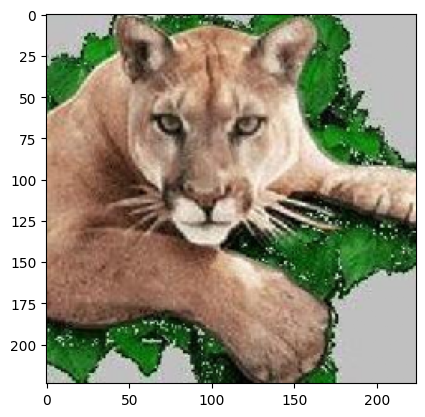

In [3]:
plt.imshow(val_images[2])

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import models


In [5]:
def VGG19(input_shape, classes=18):

    img_input = layers.Input(shape=input_shape)
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv4')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv4')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv4')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

 
        # Classification block
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
    x = layers.Dense(4096, activation='relu', name='fc2')(x)
    x = layers.Dense(classes, activation='softmax', name='predictions')(x)


    # Ensure that the model takes into account
    # any potential predecessors of input_tensor.
    
    model = models.Model(img_input, x, name='vgg19')
    model.load_weights("/kaggle/input/vgg19/tensorflow2/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5",by_name=True)
    
    return model

In [6]:
model=VGG19((224,224,3),18)

In [7]:
for layer in model.layers:
    layer.trainable = False

x = model.layers[-4].output 



x = layers.Dense(4096, activation='relu', name='fc2')(x)
x = layers.Dense(18, activation='softmax', name='predictions')(x)
new_model = Model(inputs=model.input, outputs=x)


In [8]:
import tensorflow.keras as keras

In [9]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0)

In [10]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [11]:
new_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 122,862,674 (468.68 MB)

 Trainable params: 102,838,290 (392.30 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [13]:
history = new_model.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=15,
    validation_data=(val_images, val_labels),
    callbacks=[reduce_lr]
)

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 169ms/step - accuracy: 0.2703 - loss: 14.5692 - val_accuracy: 0.7276 - val_loss: 0.8689 - learning_rate: 0.0010
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8892 - loss: 0.4031 - val_accuracy: 0.7793 - val_loss: 0.6613 - learning_rate: 0.0010
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9569 - loss: 0.1837 - val_accuracy: 0.7897 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9886 - loss: 0.0704 - val_accuracy: 0.8138 - val_loss: 0.5885 - learning_rate: 0.0010
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9937 - loss: 0.0471 - val_accuracy: 0.7931 - val_loss: 0.6728 - learning_rate: 0.0010
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 1.0000 - loss: 0.0205 - val_accuracy: 0.8207 - val_loss: 0.5941 - learning_rate: 0.0010
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 1.0000 - loss: 0.0104 - val_

In [14]:
new_model.save_weights("/kaggle/working/VGG19_.weights.h5")


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [16]:
def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1), block_id=1):
 
    channel_axis = -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    if strides == (1, 1):
        x = inputs
    else:
        x = layers.ZeroPadding2D(((0, 1), (0, 1)),
                                 name='conv_pad_%d' % block_id)(inputs)
    x = layers.DepthwiseConv2D((3, 3),
                               padding='same' if strides == (1, 1) else 'valid',
                               depth_multiplier=depth_multiplier,
                               strides=strides,
                               use_bias=False,
                               name='conv_dw_%d' % block_id)(x)
    x = layers.BatchNormalization(
        axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = layers.ReLU(6., name='conv_dw_%d_relu' % block_id)(x)

    x = layers.Conv2D(pointwise_conv_filters, (1, 1),
                      padding='same',
                      use_bias=False,
                      strides=(1, 1),
                      name='conv_pw_%d' % block_id)(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='conv_pw_%d_bn' % block_id)(x)
    return layers.ReLU(6., name='conv_pw_%d_relu' % block_id)(x)

In [17]:

def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):

    channel_axis = -1
    filters = int(filters * alpha)
    x = layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv1_pad')(inputs)
    x = layers.Conv2D(filters, kernel,
                      padding='valid',
                      use_bias=False,
                      strides=strides,
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
    return layers.ReLU(6., name='conv1_relu')(x)



In [18]:


def MobileNet(depth_multiplier=1, dropout=1e-3):
  
    global backend, layers, models, keras_utils
    # backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    rows = 224
    cols = 224
    alpha = 1.0
    img_input = layers.Input(shape=(224,224,3))

    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)

    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

    # if include_top:
    # if backend.image_data_format() == 'channels_first':
    # shape = (int(1024 * alpha), 1, 1)
        # else:
    shape = (1, 1, int(1024 * alpha))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Reshape(shape, name='reshape_1')(x)
    x = layers.Dropout(dropout, name='dropout')(x)
    x = layers.Conv2D(18, (1, 1),padding='same',name='conv_preds')(x)
    x = layers.Reshape((18,), name='reshape_2')(x)
    x = layers.Activation('softmax', name='act_softmax')(x)
    inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name='mobilenet_%0.2f_%s' % (alpha, rows))

    w_p = '/kaggle/input/mobbile/keras/default/1/mobilenet.weights.h5'
    model.load_weights(w_p)


    return model




In [19]:
model = MobileNet()

In [20]:
# optimizer =keras.optimizers.SGD(learning_rate=0.)

for layer in model.layers[:-3]:  
    layer.trainable = False
# Step 2: Compile the model and decrease overfiting 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])



In [21]:
history = model.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=15,
    validation_data=(val_images, val_labels),
    callbacks=[reduce_lr]
)

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9414 - val_loss: 0.2546 - learning_rate: 0.0010
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9483 - val_loss: 0.2488 - learning_rate: 0.0010
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss: 9.7784e-04 - val_accuracy: 0.9448 - val_loss: 0.2555 - learning_rate: 0.0010
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss: 7.3333e-04 - val_accuracy: 0.9483 - val_loss: 0.2537 - learning_rate: 0.0010
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss: 6.1165e-04 - val_accuracy: 0.9483 - val_loss: 0.2540 - learning_rate: 0.0010
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss: 5.2144e-04 - val_accuracy: 0.9483 - val_loss: 0.2561 - learning_rate: 0.0010
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss:

In [22]:
model.save_weights('mobilenet.weights.h5')

In [23]:
import pandas as pd
import numpy as np
import os
from PIL import Image


def test(model, output_file_name):
    # Test dataset configuration
    TEST_DIR = "/kaggle/input/animal-kingdom-classification/AnimalTestData/AnimalTestData"
    OUTPUT_FILE = output_file_name
    
    # Load the trained model
    # new_model.load_weights("/kaggle/working/VGG19_.weights.h5")
    
    # Prepare test data
    print("[INFO] Preparing test data...")
    test_images = []
    image_ids = []
    skipped_images = ["608.jpg", "949.jpg"]
    random_classes = np.random.randint(0, NUM_CLASSES, size=len(skipped_images))
    skipped_predictions = dict(zip(skipped_images, random_classes))
    
    for image_name in os.listdir(TEST_DIR):
        if image_name in skipped_images:
            print(f"[INFO] Skipping image {image_name} and assigning random class {skipped_predictions[image_name]}")
            continue
        img_path = os.path.join(TEST_DIR, image_name)
        try:
            img = Image.open(img_path).convert("RGB").resize((IMG_WIDTH, IMG_HEIGHT))
            test_images.append(np.asarray(img, dtype=np.float32) / 255.0)
            image_ids.append(image_name)
        except Exception as e:
            print(f"[WARNING] Skipping image {img_path}: {e}")
    
    if test_images:
        test_images = np.array(test_images)
    
        # Predict classes for test data
        print("[INFO] Predicting test data...")
        predictions = model.predict(test_images)
        predicted_classes = np.argmax(predictions, axis=1)
    
        # Add skipped images to the predictions
        for image_name, random_class in skipped_predictions.items():
            image_ids.append(image_name)
            predicted_classes = np.append(predicted_classes, random_class)
    
        # Create submission DataFrame
        submission_df = pd.DataFrame({
            "ImageID": image_ids,
            "Class": predicted_classes
        })
    
        # Save to CSV
        submission_df.to_csv(OUTPUT_FILE, index=False)
        print(f"[INFO] Submission file saved to {OUTPUT_FILE}")
    else:
        print("[ERROR] No valid images found for prediction.")


In [24]:
test(new_model, '/kaggle/working/vgg19_preds.csv')

[INFO] Preparing test data...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO] Skipping image 949.jpg and assigning random class 14
[INFO] Skipping image 608.jpg and assigning random class 3
[INFO] Predicting test data...
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step
[INFO] Submission file saved to /kaggle/working/vgg19_preds.csv


In [25]:
test(model, '/kaggle/working/mobbilenet.csv')

[INFO] Preparing test data...
[INFO] Skipping image 949.jpg and assigning random class 10
[INFO] Skipping image 608.jpg and assigning random class 8
[INFO] Predicting test data...
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step
[INFO] Submission file saved to /kaggle/working/mobbilenet.csv
